In [44]:
# ===============================
# Diabetes Risk/Protective Factor Analysis - Jupyter Notebook
# Portfolio-Ready Version
# ===============================

# ===============================
# Cell 1: Import Libraries
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")


# Diabetes Risk Analysis

This project analyzes the BRFSS 2015 dataset to identify **risk and protective factors for diabetes**, compute a **RiskScore** for each individual, and highlight the **most at-risk individuals**. The analysis also explores **income groups** and their relationship to diabetes risk.


In [45]:
# ===============================
# Cell 2: Load Dataset
# ===============================
file_path = r"data/diabetes_012_health_indicators_BRFSS2015.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}")

df = pd.read_csv(file_path)
print(f"Dataset loaded: {df.shape} rows, {df.shape[1]} columns")
df.head()


Dataset loaded: (253680, 22) rows, 22 columns


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Step 1: Correlation Matrix

I calculated correlations between each feature and the diabetes outcome (`Diabetes_012`) to identify **risk and protective factors**.  
Direct Health conditions show the strongest link to Diabetes, diet and life style are important but play a more subtle role.   

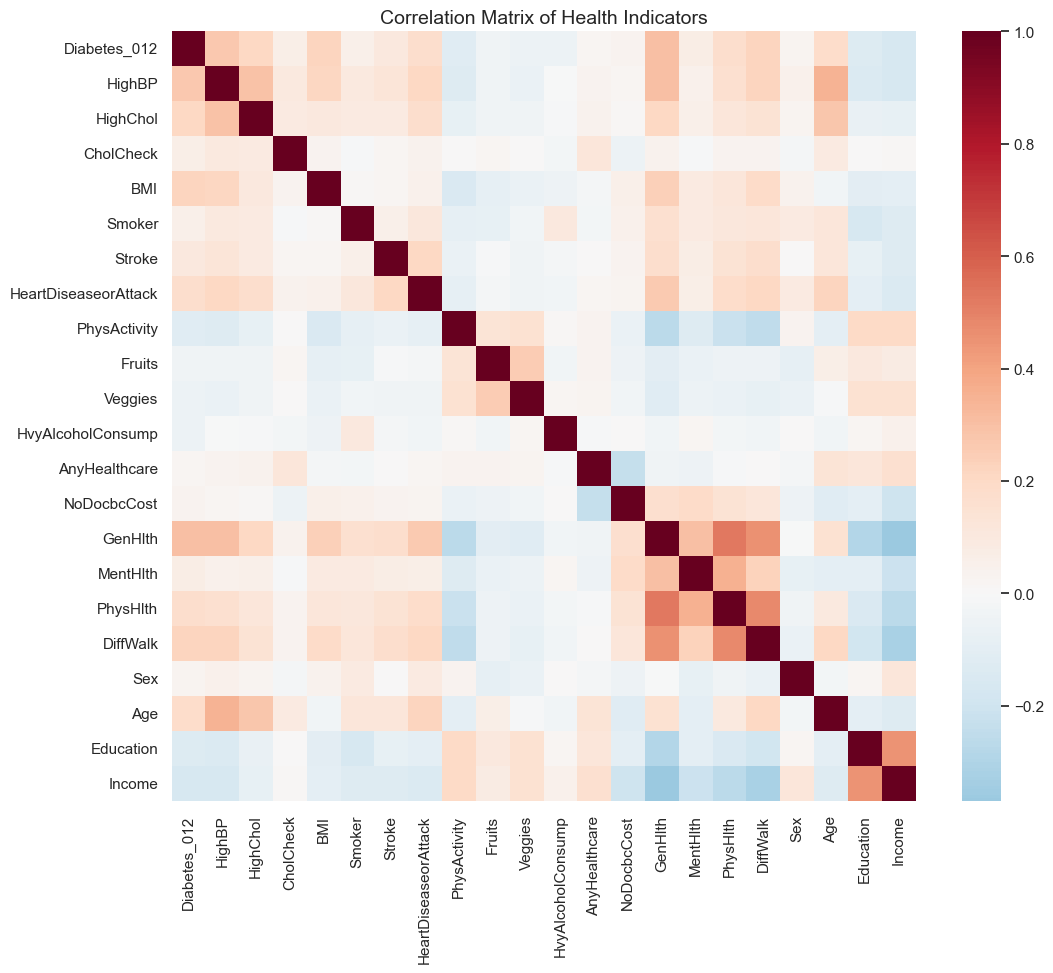

In [46]:
# ===============================
# Cell 3: Correlation Matrix
# ===============================
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("Correlation Matrix of Health Indicators", fontsize=14)
plt.savefig("images/correlation_matrix.png", bbox_inches='tight')
plt.show()



Direct health conditions show the strongest link to diabetes, while diet and lifestyle are important but play a more subtle role. For instance, fruit and vegetable consumption, though universally regarded as important, appears to have less of a positive effect than income. This may be because reported intake of fruit and vegetables is more subjective than some of the other health-related questions.

## Step 2: Identify Risk and Protective Factors
- **Risk factors**: positively correlated with diabetes  
- **Protective factors**: negatively correlated with diabetes


In [47]:
# ===============================
# Cell 4: Risk and Protective Factors
# ===============================
target = 'Diabetes_012'
correlations = corr[target].drop(target).sort_values()

risk_factors = correlations[correlations > 0].index.tolist()
protective_factors = correlations[correlations < 0].index.tolist()

# Display as a table
risk_table = pd.DataFrame({"Risk Factors": risk_factors})
protective_table = pd.DataFrame({"Protective Factors": protective_factors})

display(risk_table)
display(protective_table)


,Risk Factors
0,AnyHealthcare
1,Sex
2,NoDocbcCost
3,Smoker
4,CholCheck
5,MentHlth
6,Stroke
7,PhysHlth
8,HeartDiseaseorAttack
9,Age


,Protective Factors
0,Income
1,Education
2,PhysActivity
3,Veggies
4,HvyAlcoholConsump
5,Fruits


Visual Analysis of Most Common Risk Factors
# 
# This section provides comprehensive visualizations of the risk factors identified in my analysis.


## Step 3: Compute RiskScore

Since the dataset contains features with different ranges, I used StandardScaler to put them on the same scale and then computed a RiskScore as:

RiskScore = sum of standardized risk factors − sum of standardized protective factors.”**


In [48]:
# ===============================
# Cell 5: Standardize Features & Compute RiskScore + RiskLevel
# ===============================

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1. Standardize all risk and protective factors
scaler = StandardScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(df[risk_factors + protective_factors]),
    columns=risk_factors + protective_factors
)

# 2. Compute raw RiskScore
df['RiskScore'] = (
    scaled[risk_factors].sum(axis=1)
    - scaled[protective_factors].sum(axis=1)
)

# 3. Define quantile thresholds for categories
q_low  = df['RiskScore'].quantile(0.50)   # medium cutoff (50th percentile)
q_high = df['RiskScore'].quantile(0.90)   # high-risk cutoff (90th percentile)

# 4. Assign Low/Medium/High risk levels
df['RiskLevel'] = pd.cut(
    df['RiskScore'],
    bins=[-np.inf, q_low, q_high, np.inf],
    labels=['Low', 'Medium', 'High']
)

# 5. (Optional) Quick check of category counts
display(df['RiskLevel'].value_counts())


RiskLevel
Low       126840
Medium    101472
High       25368
Name: count, dtype: int64

Most people in the dataset fall into the low to moderate risk category. However, a significant number are in the moderate risk group, and while fewer in number, there are unfortunately some individuals in the high-risk group, whom I will later identify for further intervention.

## Step 4: Average RiskScore by Diabetes Status


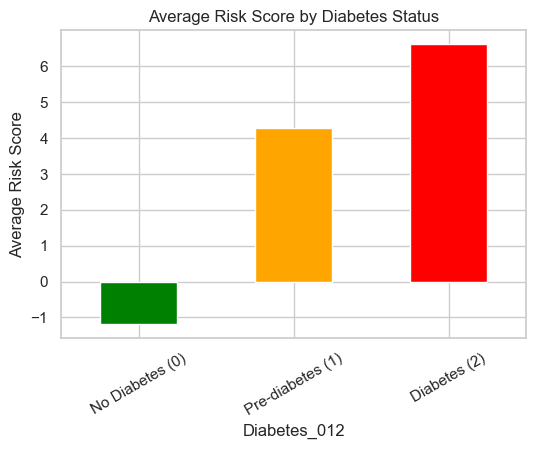

,Diabetes Status,Average Risk Score
0,No Diabetes (0),-1.185651
1,Pre-diabetes (1),4.274329
2,Diabetes (2),6.608462


In [49]:
# ===============================
# Cell 6: Average RiskScore by Diabetes Status
# ===============================
group_scores = df.groupby(target)['RiskScore'].mean()

plt.figure(figsize=(6, 4))
group_scores.plot(kind="bar", color=["green", "orange", "red"])
plt.title("Average Risk Score by Diabetes Status")
plt.ylabel("Average Risk Score")
plt.xticks([0, 1, 2], ["No Diabetes (0)", "Pre-diabetes (1)", "Diabetes (2)"], rotation=30)
plt.savefig("images/avg_risk_by_status.png", dpi=300, bbox_inches='tight')
plt.show()

# Table
scores_df = pd.DataFrame({
    'Diabetes Status': ['No Diabetes (0)', 'Pre-diabetes (1)', 'Diabetes (2)'],
    'Average Risk Score': group_scores.values
})
display(scores_df)


The chart shows that individuals with pre-diabetes have average risk scores closer to those with diabetes than to those without. This pattern can be explained by several factors:
- Risk Score Composition: Pre-diabetic individuals often show elevated values in key health indicators (e.g. glucose, BMI), which heavily influence the risk score.
- Distribution Skew: The "No Diabetes" group may include many low-risk individuals, pulling its average down, while the pre-diabetes group is more tightly clustered around moderate-to-high scores.
- Shared Risk Factors: Pre-diabetes and diabetes share many underlying risk factors—just at different thresholds—leading to similar scoring profiles.
This suggests that pre-diabetes is not just a mild deviation from normal health, but often a strong signal of elevated risk—potentially warranting early intervention.


## Step 5: High-Risk Individuals (Top 10%)


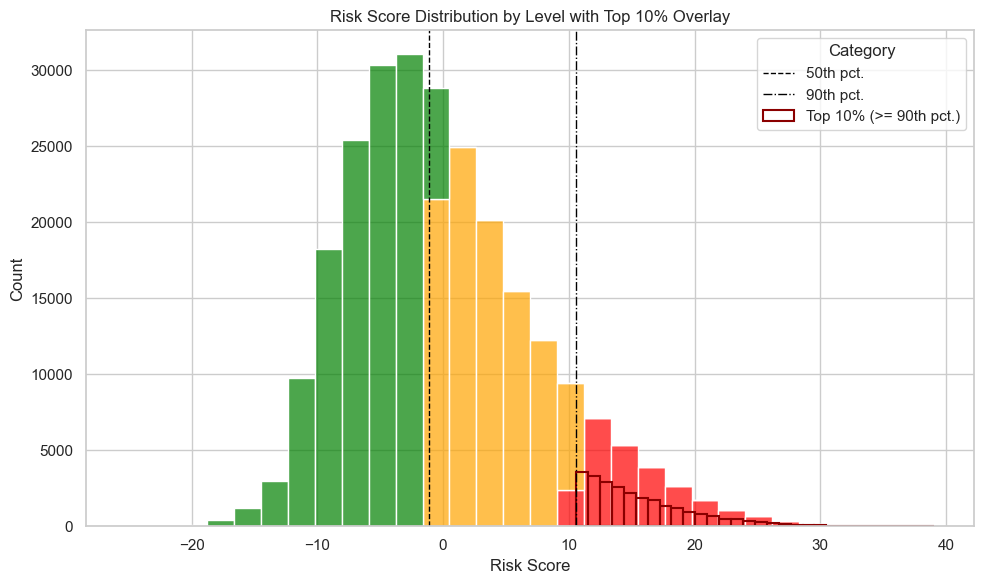

In [50]:
# ===============================
# Cell 7: Distribution with RiskLevel Bands + Top 10% Outline
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-compute 90th percentile threshold (for your red outline)
threshold = df['RiskScore'].quantile(0.90)

# 2. Plot full-distribution, stacked by RiskLevel
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='RiskScore',
    hue='RiskLevel',
    bins=30,
    palette={'Low': 'green', 'Medium': 'orange', 'High': 'red'},
    multiple='stack',
    edgecolor='w',
    alpha=0.7
)

# 3. Overlay outline of the Top 10% (High-Risk) subset
high = df[df['RiskScore'] >= threshold]['RiskScore']
sns.histplot(
    high,
    bins=30,
    color='none',
    edgecolor='darkred',
    linewidth=1.5,
    alpha=1,
    label='Top 10% (>= 90th pct.)'
)

# 4. Mark the 50th and 90th percentile cut-points
q50 = df['RiskScore'].quantile(0.50)
plt.axvline(q50,  color='black', linestyle='--', linewidth=1, label='50th pct.')
plt.axvline(threshold, color='black', linestyle='-.', linewidth=1, label='90th pct.')

# 5. Final tweaks
plt.title('Risk Score Distribution by Level with Top 10% Overlay')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend(title='Category', loc='upper right')
plt.tight_layout()
plt.show()

## Step 5: High-Risk Individuals (Top 10%)


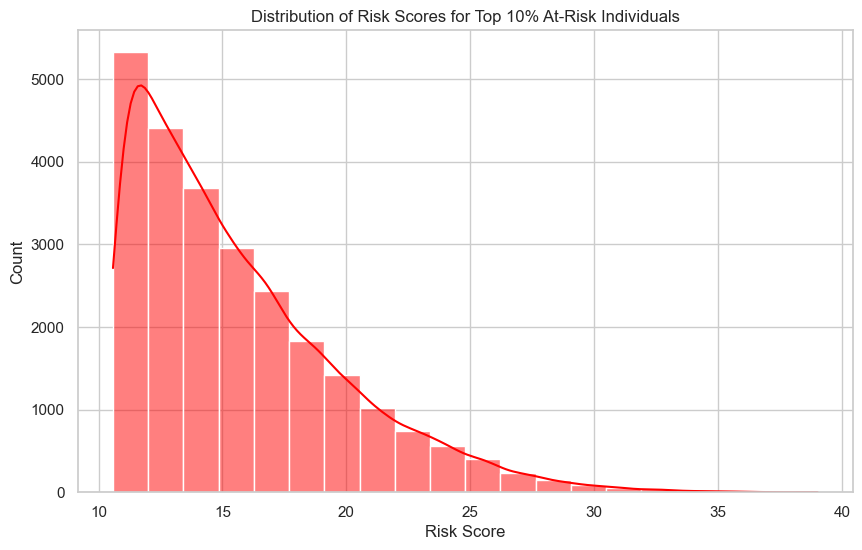

,User Reference,Diabetes Status,Risk Score,Top Risk Features
125316,User_125316,2.000000,39.015752,"PhysHlth, GenHlth, DiffWalk"
175620,User_175620,2.000000,36.843539,"PhysHlth, GenHlth, DiffWalk"
212060,User_212060,2.000000,36.378560,"PhysHlth, GenHlth, DiffWalk"
73531,User_73531,2.000000,36.135917,"PhysHlth, GenHlth, DiffWalk"
43423,User_43423,0.000000,35.630625,"PhysHlth, GenHlth, DiffWalk"
150916,User_150916,2.000000,35.504104,"PhysHlth, GenHlth, DiffWalk"
224827,User_224827,2.000000,35.490690,"PhysHlth, GenHlth, DiffWalk"
176186,User_176186,2.000000,35.418050,"PhysHlth, GenHlth, DiffWalk"
57219,User_57219,2.000000,35.319019,"PhysHlth, GenHlth, DiffWalk"
144955,User_144955,2.000000,35.117431,"PhysHlth, GenHlth, DiffWalk"


In [51]:
# ===============================
# Cell 7: High-Risk Individuals
# ===============================

# Define threshold for top 10% risk
threshold = df['RiskScore'].quantile(0.90)
high_risk_individuals = df[df['RiskScore'] >= threshold].copy()

# Define risk factors (ensure this is defined earlier in your notebook)
risk_factors = ['GenHlth', 'DiffWalk', 'PhysHlth', 'HighBP', 'HeartDiseaseorAttack']

# Function to extract top N contributing features
def top_risk_features(row, n=3):
    return ', '.join(row[risk_factors].sort_values(ascending=False).head(n).index.tolist())

# Apply feature extraction
high_risk_individuals['Top_Risk_Features'] = high_risk_individuals.apply(top_risk_features, axis=1)

# Create synthetic User Reference column
high_risk_individuals['User Reference'] = ['User_' + str(i) for i in high_risk_individuals.index]

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(high_risk_individuals['RiskScore'], bins=20, kde=True, color="red")
plt.title("Distribution of Risk Scores for Top 10% At-Risk Individuals")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.savefig("images/high_risk_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Display styled table of top 10 individuals
table_df = high_risk_individuals[['User Reference', target, 'RiskScore', 'Top_Risk_Features']] \
    .sort_values('RiskScore', ascending=False) \
    .head(10) \
    .rename(columns={
        target: 'Diabetes Status',
        'RiskScore': 'Risk Score',
        'Top_Risk_Features': 'Top Risk Features'
    })

table_df.style.set_caption("🔍 Top 10 High-Risk Individuals (Based on Risk Score)") \
    .background_gradient(subset=['Risk Score'], cmap='Reds') \
    .set_properties(**{'text-align': 'left'})

## Step 6: High-Risk Non-Diabetic / Pre-Diabetic Individuals


C:\Users\leonw\AppData\Local\Temp\ipykernel_24136\1019694969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_non_diabetic['Top_Risk_Features'] = high_risk_non_diabetic.apply(top_risk_features, axis=1)


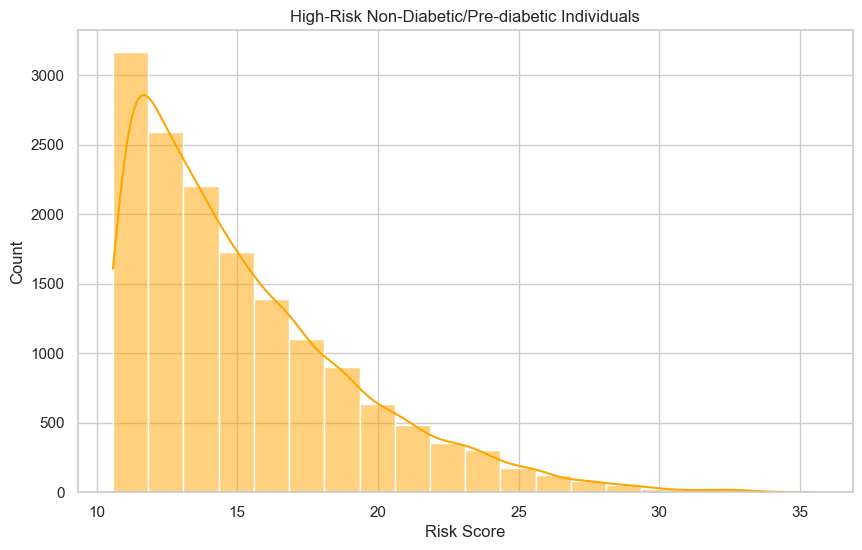

,Diabetes_012,RiskScore,Top_Risk_Features
43423,0.0,35.630625,"PhysHlth, GenHlth, DiffWalk"
206840,0.0,34.543106,"PhysHlth, GenHlth, DiffWalk"
18802,0.0,33.811553,"PhysHlth, GenHlth, DiffWalk"
210293,0.0,33.661779,"PhysHlth, GenHlth, DiffWalk"
16748,0.0,33.236955,"PhysHlth, GenHlth, HighBP"
50683,1.0,33.119712,"PhysHlth, GenHlth, DiffWalk"
224752,0.0,33.078780,"PhysHlth, GenHlth, DiffWalk"
207482,0.0,33.026138,"GenHlth, PhysHlth, DiffWalk"
1940,0.0,32.930087,"PhysHlth, GenHlth, DiffWalk"
174831,0.0,32.882679,"PhysHlth, GenHlth, DiffWalk"


,Factor,Impact,Type
0,GenHlth,0.671176,Risk
1,DiffWalk,0.585545,Risk
2,PhysHlth,0.550730,Risk
5,Income,-0.507370,Protective
3,HighBP,0.494741,Risk
6,Education,-0.442475,Protective
4,HeartDiseaseorAttack,0.430825,Risk
7,PhysActivity,-0.424512,Protective
8,Veggies,-0.314571,Protective
9,Fruits,-0.276144,Protective


In [52]:
# ===============================
# Cell 8: High-Risk Non-Diabetic/Pre-Diabetic
# ===============================
high_risk_non_diabetic = high_risk_individuals[high_risk_individuals[target] != 2]
high_risk_non_diabetic['Top_Risk_Features'] = high_risk_non_diabetic.apply(top_risk_features, axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(high_risk_non_diabetic['RiskScore'], bins=20, kde=True, color="orange")
plt.title("High-Risk Non-Diabetic/Pre-diabetic Individuals")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.savefig("images/high_risk_non_diabetic.png", dpi=300, bbox_inches='tight')
plt.show()

display(high_risk_non_diabetic[['Diabetes_012','RiskScore','Top_Risk_Features']].sort_values('RiskScore', ascending=False).head(10))
# Convert to Series
risk_series = pd.Series(risk_factors, name='RiskScore Impact')
protective_series = pd.Series(protective_factors, name='RiskScore Impact')

# Add a label column
risk_df = pd.DataFrame({'Factor': risk_series.index, 'Impact': risk_series.values, 'Type': 'Risk'})
protective_df = pd.DataFrame({'Factor': protective_series.index, 'Impact': protective_series.values, 'Type': 'Protective'})

# Combine both
combined_df = pd.concat([risk_df, protective_df], ignore_index=True)

# Risk factors
risk_factors = {
    'GenHlth': 0.671176,
    'DiffWalk': 0.585545,
    'PhysHlth': 0.550730,
    'HighBP': 0.494741,
    'HeartDiseaseorAttack': 0.430825
}

# Protective factors
protective_factors = {
    'Income': -0.507370,
    'Education': -0.442475,
    'PhysActivity': -0.424512,
    'Veggies': -0.314571,
    'Fruits': -0.276144
}

# Convert to Series
risk_series = pd.Series(risk_factors, name='RiskScore Impact')
protective_series = pd.Series(protective_factors, name='RiskScore Impact')

# Add a label column
risk_df = pd.DataFrame({'Factor': risk_series.index, 'Impact': risk_series.values, 'Type': 'Risk'})
protective_df = pd.DataFrame({'Factor': protective_series.index, 'Impact': protective_series.values, 'Type': 'Protective'})

# Combine both
combined_df = pd.concat([risk_df, protective_df], ignore_index=True)

# Sort by absolute impact (optional)
combined_df['AbsImpact'] = combined_df['Impact'].abs()
combined_df = combined_df.sort_values(by='AbsImpact', ascending=False)

# Drop helper column if not needed
combined_df.drop(columns='AbsImpact', inplace=True)

# Display
combined_df.style.set_caption("Top Factors Impacting RiskScore").background_gradient(subset=['Impact'], cmap='coolwarm')





## Step 7: Income Analysis (4 Groups)


C:\Users\leonw\AppData\Local\Temp\ipykernel_24136\3788231791.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_risk = df.groupby('IncomeGroup')['RiskScore'].mean()


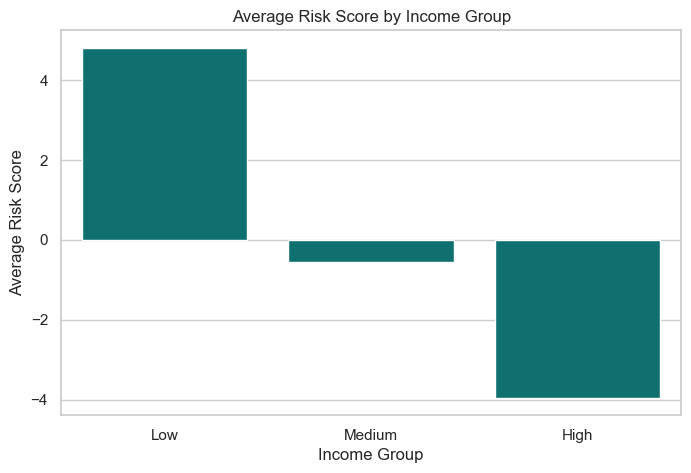

C:\Users\leonw\AppData\Local\Temp\ipykernel_24136\3788231791.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_diabetes = df.groupby(['IncomeGroup', target]).size().unstack(fill_value=0)


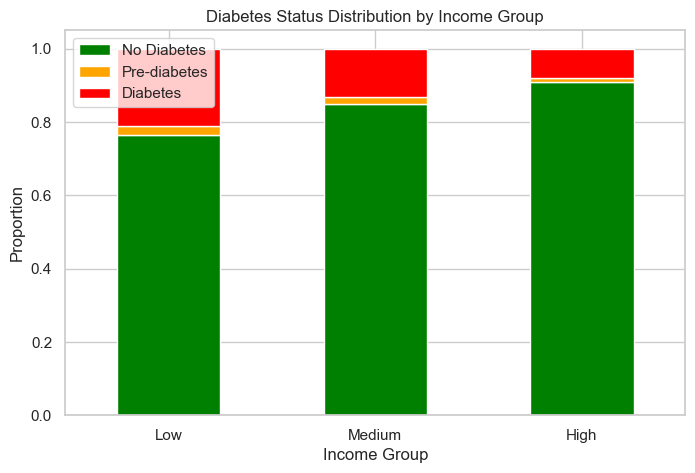

In [53]:
# ===============================
# Cell 9: Income Analysis
# ===============================
if 'Income' in df.columns:
    income_groups = pd.qcut(df['Income'], q=4, duplicates='drop')
    n_groups = income_groups.cat.categories.size
    labels = ['Low', 'Medium', 'High', 'Very High'][:n_groups]
    df['IncomeGroup'] = income_groups.cat.rename_categories(labels)
    
    # Average RiskScore by IncomeGroup
    income_risk = df.groupby('IncomeGroup')['RiskScore'].mean()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=income_risk.index, y=income_risk.values, color='teal')
    plt.title("Average Risk Score by Income Group")
    plt.xlabel("Income Group")
    plt.ylabel("Average Risk Score")
    plt.savefig("images/income_risk.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Diabetes prevalence by income group
income_diabetes = df.groupby(['IncomeGroup', target]).size().unstack(fill_value=0)

# Rename columns for readability
income_diabetes.columns = ['No Diabetes', 'Pre-diabetes', 'Diabetes']

# Convert to proportions
income_diabetes_prop = income_diabetes.div(income_diabetes.sum(axis=1), axis=0)

# Plot stacked bar chart
income_diabetes_prop.plot(kind='bar', stacked=True, figsize=(8,5), color=['green','orange','red'])
plt.title("Diabetes Status Distribution by Income Group")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.xticks(rotation=0)
plt.savefig("images/income_diabetes_status.png", dpi=300, bbox_inches='tight')
plt.show()


## Comparing Risk vs Protective Factors
This section explores which factors contribute more to overall diabetes risk, and which are most actionable for reducing risk.



In [54]:
# Separate risk and protective scores
df['RiskScore_only'] = scaled[risk_factors].sum(axis=1)
df['ProtectiveScore_only'] = scaled[protective_factors].sum(axis=1)

# Boxplot of Risk factors by diabetes status
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x=target, y='RiskScore_only', color='red')
plt.title("Distribution of Risk Factors by Diabetes Status")
plt.savefig("images/risk_factors_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()

# Boxplot of Protective factors by diabetes status
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x=target, y='ProtectiveScore_only', color='green')
plt.title("Distribution of Protective Factors by Diabetes Status")
plt.savefig("images/protective_factors_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()

TypeError: Passing a dict as an indexer is not supported. Use a list instead.

In [ ]:
# Correlation of each factor with overall RiskScore
risk_corr = df[risk_factors].corrwith(df['RiskScore']).sort_values(ascending=False)
protect_corr = df[protective_factors].corrwith(df['RiskScore']).sort_values()

# Display top contributors
print("Top Risk Factors Impacting RiskScore:")
print(risk_corr.head(5))
print("\nTop Protective Factors Impacting RiskScore:")
print(protect_corr.head(5))


Top Risk Factors Impacting RiskScore:
GenHlth                 0.671176
DiffWalk                0.585545
PhysHlth                0.550730
HighBP                  0.494741
HeartDiseaseorAttack    0.430825
dtype: float64

Top Protective Factors Impacting RiskScore:
Income         -0.507370
Education      -0.442475
PhysActivity   -0.424512
Veggies        -0.314571
Fruits         -0.276144
dtype: float64


# Key Insights (Markdown Cell)

1. Major risk factors: `AnyHealthcare`, `Sex`, `NoDocbcCost`, `Smoker`, `CholCheck`, `MentHlth`, etc.  
2. Protective factors: `Income`, `Education`, `PhysActivity`, `Veggies`, `Fruits`.  
3. Top 10% high-risk individuals are highlighted by RiskScore.  
4. Income groups show differences in diabetes risk, though some factors like lifestyle changes (e.g., physical activity, diet) are actionable to reduce personal risk.  
